## SQuASH Integration into Custom QAS 

In this notebook, we see on the example of reinfocement learning driven QAS method how to integrate the benchmark into the custom method. Similar to previous notebooks, we first ensure proper dependency loading. 

In [1]:
# Suppress PyTorch Warnings and ensure proper dependency loading
import warnings
import os
import sys

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) # Go two levels up from the notebook location to reach project root

if project_root not in sys.path:
    sys.path.insert(0, project_root)
print("Project root set to:", project_root)

Project root set to: C:\SQuASH


## Import dependencies

In [2]:
import time
import numpy as np
from qiskit.circuit import Parameter
from examples.rl_utils import (
    get_all_parametrized_one_q_qates,
    get_parametrized_controlled_two_q_gates,
    get_parametrized_uncontrolled_two_q_gates
)

## 🌎 Defining the Environment

The goal of the agent is to construct quantum circuits that prepare a specific target quantum state — in this case, the three-qubit GHZ state, defined as:
$$
|\text{GHZ}_3\rangle = \frac{1}{\sqrt{2}}(|000\rangle + |111\rangle)
$$
To achieve this, the agent interacts with an environment modeled as a (parametrized) quantum circuit. Here, the design of the environment is defined by the search space `ghz_a`. At each discrete time step $t$, the agent selects an **action $a_t$𝑡**, which corresponds to applying a quantum gate from the allowed gate set:
$$
\mathcal{G}_{\text{ghz\_a}} = \{\text{cx}, \text{h}, \text{rx}, \text{ry}, \text{rz}, \text{id}\}
$$

This action is applied to the circuit, modifying the current quantum state $|\psi_t\rangle \in \mathbb{C}^{2^n}$, where $𝑛=3$ is the number of qubits. The quantum state is updated according to the gate's operation and any parametrized rotation angles $\theta$.

The environment observes the updated quantum state after each action. With this, the RL **state** is represented by its statevector  $|\psi_t>$.

### Reusable environment `QuantumCircuitEnv`

First, we define a broader environment `QuantumCircuitEnv`, which is reusable for different tasks. For this purpose, we use the `gymnasium` library. 

In [3]:
#!pip install gymnasium==0.29.1
#!pip install stable_baselines3==2.5.0

In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import Aer

from examples.rl_utils import split_gate_set, get_num_actions_from_gate_set_and_layers, get_exec_time


class QuantumCircuitEnv(gym.Env):
    def __init__(self, task, gate_set, layer_set, num_qubits=3, seed=None, start_time=None):
        super(QuantumCircuitEnv, self).__init__()
        self.gate_set = gate_set
        self.num_qubits = num_qubits
        self.layer_set = layer_set
        self.one_q_unparam_gates, self.one_q_param_gates, self.unparam_uncont_two_qubit_gates, self.unparam_cont_two_qubit_gates, self.param_uncont_two_qubit_gates, self.param_cont_two_qubit_gates = split_gate_set(
            self.gate_set)
        self.current_step = 0
        self.global_step = 0
        self.total_reward = 0.0
        self.reward_list = []
        self.time_reward_log = []
        self.start_time = start_time
        self.action_cache = {}
        self.seed = seed

        num_actions = get_num_actions_from_gate_set_and_layers(self.gate_set, self.layer_set, self.num_qubits)
        self.action_space = spaces.Discrete(num_actions)
        self.observation_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(pow(2, num_qubits + 1),),
            dtype=np.float64
        )

        self.state = np.zeros(2 ** self.num_qubits * 2, dtype=np.float64)
        self.task = task
        self.circuit = QuantumCircuit(self.num_qubits)

    def reset(self, seed=None, options=None):
        super().reset(seed=self.seed)
        self.current_step = 0
        self.total_reward = 0.0
        self.circuit = QuantumCircuit(self.num_qubits)
        self.state = np.zeros(2 ** self.num_qubits * 2, dtype=np.float64)
        return self.state, {}

    def cache_one_qubit_gates(self, action_count):
        for gate in self.one_q_unparam_gates:
            for qubit in range(self.num_qubits):
                self.action_cache[action_count] = (gate, [qubit], None)
                action_count += 1
        for gate in self.one_q_param_gates:
            for qubit in range(self.num_qubits):
                    self.action_cache[action_count] = (gate, [qubit], 0)
                    action_count += 1
        return action_count

    def cache_unparametrized_uncontrolled_two_qubit_gates(self, action_count):
        for gate in self.unparam_uncont_two_qubit_gates:
            for q1 in range(self.num_qubits - 1):
                for q2 in range(q1 + 1, self.num_qubits):
                    self.action_cache[action_count] = (gate, [q1, q2], None)
                    action_count += 1
        return action_count

    def cache_unparametrized_controlled_two_qubit_gates(self, action_count):
        for gate in self.unparam_cont_two_qubit_gates:
            for q1 in range(self.num_qubits - 1):
                for q2 in range(q1 + 1, self.num_qubits):
                    self.action_cache[action_count] = (gate, [q1, q2], None)
                    action_count += 1
                    self.action_cache[action_count] = (gate, [q2, q1], None)
                    action_count += 1
        return action_count

    def cache_parametrized_uncontrolled_two_qubit_gates(self, action_count):
        for gate in self.param_uncont_two_qubit_gates:
                for q1 in range(self.num_qubits - 1):
                    for q2 in range(q1 + 1, self.num_qubits):
                        self.action_cache[action_count] = (gate, [q1, q2], 0)
                        action_count += 1
        return action_count

    def cache_parametrized_controlled_two_qubit_gates(self, action_count):
        for gate in self.param_cont_two_qubit_gates:
                for q1 in range(self.num_qubits - 1):
                    for q2 in range(q1 + 1, self.num_qubits):
                        self.action_cache[action_count] = (gate, [q1, q2], 0)
                        action_count += 1
                        self.action_cache[action_count] = (gate, [q2, q1], 0)
                        action_count += 1
        return action_count


    def _populate_cache(self):
        action_count = 0
        action_count = self.cache_one_qubit_gates(action_count)
        action_count = self.cache_unparametrized_uncontrolled_two_qubit_gates(action_count)
        action_count = self.cache_parametrized_uncontrolled_two_qubit_gates(action_count)
        action_count = self.cache_unparametrized_controlled_two_qubit_gates(action_count)
        action_count = self.cache_parametrized_controlled_two_qubit_gates(action_count)


    def _convert_gates(self, gate, qubits, param):
        pass

    def _convert_parametrized_layer(self, layer_name, param):
        pass

    def _convert_action(self, action):
        pass


    def step(self, action, train=True, random=False):
        pass

    def render(self, mode='human'):
        pass

    def get_info_and_simulator(self):
        info = {}
        backend = Aer.get_backend('statevector_simulator')
        return info, backend


### Environment `StatePreparationEnvironmentTrainable`

Now, we specify the environment `StatePreparationEnvironmentTrainable`, which is specific for the state preparation.  

🔹 Environment Foundation:
We extend a general-purpose quantum circuit environment to create a specialized version that supports trainable state preparation tasks.

🔹 Parametrized Quantum Gates:
Quantum circuits in this task use gates that can be tuned using parameters (like rotation angles). Each time the agent adds such a gate, a new parameter is first assigned to 0.
Bevor the circuit is optimized, parameteres are reassigned uniformly in the range [-0.01, 0.01], which is conform to the search space `ghz_a`.

🔹 Surrogate Model Support:
We enable the evaluation of circuits by surrogate model, if the `self.predictor` is set to True.

🔹 Action Translation:
The environment takes discrete actions from the agent and translates them into meaningful circuit-building steps: placing gates, adding parametrized layers, or entangling qubits.

🔹 Reward Mechanism:
The environment computes a reward based on how close the constructed quantum circuit comes to the desired quantum state. A higher reward means a better match.

🔹  Monitoring:
Every few hundred steps, the environment logs average performance. When an episode ends, the system records fidelity, reward, and training time—so we can monitor learning progress.

In [31]:
from benchmark.utils import load_gnn_benchmark_model

class StatePreparationEnvironmentTrainable(QuantumCircuitEnv):
    def __init__(self, task, gate_set, layer_set=[], num_qubits=3, seed=None, start_time=None):
        super().__init__(task, gate_set, layer_set, num_qubits, seed, start_time)
        self.predictor = None
        self.proxy = False
        self.num_parameters = 0
        self.seed = seed

    def init_predictor(self, search_space, model_name, proxy):
        self.predictor = load_gnn_benchmark_model(model_name, search_space=search_space, device="cpu")
        self.proxy = proxy

    def get_new_param(self):
        param = Parameter(f'θ{self.num_parameters}')
        self.num_parameters += 1
        return param

    def _is_parametrized_gate(self, gate):
        return (
            gate in get_all_parametrized_one_q_qates() or
            gate in get_parametrized_controlled_two_q_gates() or
            gate in get_parametrized_uncontrolled_two_q_gates()
        )

    def get_new_param(self):
        param_name = f'θ{self.num_parameters}'
        self.num_parameters += 1
        return Parameter(param_name)

    def _convert_gates(self, gate, qubits, param):
        theta = self.get_new_param()
        if gate in get_all_parametrized_one_q_qates() or gate in get_parametrized_controlled_two_q_gates() or gate in get_parametrized_uncontrolled_two_q_gates():
            getattr(self.circuit, gate)(theta, *qubits)
        else:
            getattr(self.circuit, gate)(*qubits)


    def _convert_action(self, action):
        if not self.action_cache:
            self._populate_cache()

        if action in self.action_cache:
            gate, qubits, param = self.action_cache[action]
            self._convert_gates(gate, qubits, param)
        else:
            raise ValueError(f"Action {action} is illegal.")

    def step(self, action, train=True, random=False):
        super().step(action, train)
        info, simulator = self.get_info_and_simulator()
        info["circuit"] = self.circuit.copy()
        #print("self.circuit.draw()", self.circuit.draw())

        reward, done, fidelity, statevector = self.task.compute_reward(
            self.circuit,  train=train, predictor=self.predictor, proxy=self.proxy
        )

        self.state = np.concatenate([statevector.data.real, statevector.data.imag])
        info["fidelity"] = fidelity
        self.total_reward += reward

        if done:
            self._handle_episode_end(info, train, random)

        if self.global_step > 0 and self.global_step % 300 == 0:
            self._log_performance()

        self.current_step += 1
        self.global_step += 1
        return self.state, reward, done, done, info

    def _handle_episode_end(self, info, train, random):
        self.num_parameters = 0
        self.reward_list.append(self.total_reward)
        elapsed_time = (time.time() - self.start_time) / 60.0
        self.time_reward_log.append(elapsed_time)

        info.update({
            "elapsed_time": elapsed_time,
            "total_reward": self.total_reward
        })
        self.total_reward = 0.0
        self.state, _ = self.reset()

    def _log_performance(self):
        print(f"{self.global_step} steps are finished.")
        last_rewards = self.reward_list[-300:]
        if last_rewards:
            mean_reward = sum(last_rewards) / len(last_rewards)
            print(f"Mean episode reward: {mean_reward}")

 ## 🧠 Defining the Task Class

To interact with our custom `StatePreparationEnvironmentTrainable`  Gym environment, we need to define a task. A task encapsulates everything that makes the problem meaningful and solvable — from generating data and visualizations to computing rewards for a given quantum circuit.

Let´s define a class called `GHZTaskTrainable` with custom logic for generating the target state and computing the reward.

In [6]:
from qiskit import transpile

from qiskit.quantum_info import state_fidelity
from scipy.optimize import minimize
from qiskit import qasm3

from benchmark.search_spaces.ghz_a.generate_target_ghz_a import get_ghz_a_target
from benchmark.search_spaces.ghz_a.ghz_a_search_space_config import ghz_a_conf
from benchmark.utils import predict_circuit_performance, convert_qasm_circuit_into_trainable_pqc

class GHZTaskTrainable():
    def __init__(self, name, num_qubits: int = None):
        print(f"Initialize {name} task")
        self.num_qubits = num_qubits
        self.target_statevector = get_ghz_a_target()
        self.circuit_id = 0
        self.bound_circuit = None
        self.statevector = None
        self.depth = None

    @staticmethod
    def get_reward_return(fidelity: float = None, circuit_depth: int = None, statevector=None):
        if fidelity >= 0.95 or circuit_depth >= ghz_a_conf["max_depth"]:
            return fidelity, True, fidelity, statevector
        else:
            return -0.1, False, fidelity, statevector

    def optimize(self, circuit):
        initial_param_min = ghz_a_conf["initial_param_min"]
        initial_param_max = ghz_a_conf["initial_param_max"]
        optimizer = ghz_a_conf["optimizer"]
        max_iter = ghz_a_conf["optimizer_maxiter"]
        optimal_fidelity = None
        initial_params = np.random.uniform(initial_param_min, initial_param_max, len(circuit.parameters))
        bounds = [(-np.pi, np.pi)] * len(circuit.parameters) if circuit.parameters else None

        def fidelity_loss(params):
            param_dict = dict(zip(circuit.parameters, params))
            if params.__sizeof__() > 0:
                self.bound_circuit = circuit.assign_parameters(param_dict)
            else:
                self.bound_circuit = circuit
            self.depth = self.bound_circuit.depth()
            backend = Aer.get_backend('statevector_simulator')
            transpiled_circuit = transpile(self.bound_circuit, backend)
            job = backend.run(transpiled_circuit)
            job_result = job.result()
            self.statevector = job_result.get_statevector()
            fidelity = state_fidelity(self.statevector, self.target_statevector)
            return -fidelity

        if circuit.parameters:
            try:
                result = minimize(fidelity_loss,
                                  initial_params,
                                  method=optimizer,
                                  options={'maxiter': max_iter},
                                  bounds=bounds)
                optimal_fidelity = result.fun
            except Exception as e:
                print(f"[ERROR] Optimization failed:{e}")
                print(circuit.draw())
        else:
            optimal_fidelity = fidelity_loss(initial_params)
        return optimal_fidelity, self.depth

    def compute_reward(self, circuit: QuantumCircuit = None, train=True, predictor=None, proxy=None):
        if predictor and (train):
            initial_param_min = ghz_a_conf["initial_param_min"]
            initial_param_max = ghz_a_conf["initial_param_max"]
            initial_params = np.random.uniform(initial_param_min, initial_param_max, len(circuit.parameters))
            param_dict = dict(zip(circuit.parameters, initial_params))
            if initial_params.__sizeof__() > 0:
                self.bound_circuit = circuit.assign_parameters(param_dict)
            else:
                self.bound_circuit = circuit
            optimal_fidelity = predict_circuit_performance(qasm3.dumps(self.bound_circuit),
                                                            model=predictor,
                                                            gate_set=ghz_a_conf["gate_set"],
                                                            proxy=proxy)
            circuit_depth = self.bound_circuit.depth()
            backend = Aer.get_backend('statevector_simulator')
            transpiled_circuit = transpile(self.bound_circuit, backend)
            job = backend.run(transpiled_circuit)
            job_result = job.result()
            self.statevector = job_result.get_statevector()
        else:
            optimal_fidelity, circuit_depth = self.optimize(circuit)
        return self.get_reward_return(optimal_fidelity, circuit_depth, self.statevector)


# Train the agent

In [7]:
from stable_baselines3.common.callbacks import BaseCallback


class LossLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(LossLoggingCallback, self).__init__(verbose)
        self.policy_loss = []
        self.value_loss = []
        self.loss_history = []

    def _on_step(self) -> bool:
        policy_loss = self.model.logger.name_to_value.get("train/policy_gradient_loss", None)
        value_loss = self.model.logger.name_to_value.get("train/value_loss", None)
        loss = self.model.logger.name_to_value.get("train/loss", None)

        if policy_loss is not None:
            self.policy_loss.append(policy_loss)
        if value_loss is not None:
            self.value_loss.append(value_loss)
        if loss is not None:
            self.loss_history.append(loss)
        return True

In [8]:
from examples.rl_utils import set_seed, plot_results
from stable_baselines3 import DQN
from torch import optim

def create_env(ghz_a_conf, seed, start_time=None, predictor=False, model_name=None):
    task = GHZTaskTrainable(name="state preparation ghz 3 qubits", num_qubits=ghz_a_conf["num_qubits"])
    env = StatePreparationEnvironmentTrainable(task=task, num_qubits=ghz_a_conf["num_qubits"],
                                                   gate_set=ghz_a_conf["gate_set"], 
                                                   seed=seed, start_time=start_time)
    env.predictor = predictor
    if env.predictor:
        env.init_predictor(search_space="ghz_a", model_name="gcn_augmented_ghz_a", proxy=False)
    env.action_space.seed(seed)
    return env

def train_agent(env, model_name, total_timesteps, seed):
    env.global_step = 0
    env.reward_list = []
    start_time = time.time()
    print(f"Start training of the DQN model.")
    policy_kwargs = dict(optimizer_class=optim.Adam, normalize_images=False)
    model_ = model_name(policy="MlpPolicy", env=env,
                        seed=seed,
                        device="cpu",
                        learning_rate=0.0003, policy_kwargs=policy_kwargs)
    callback_ = LossLoggingCallback()
    model_.learn(total_timesteps=total_timesteps, callback=callback_, progress_bar=False)
    loss = callback_.loss_history
    reward_list = env.reward_list
    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training execution time: {execution_time_minutes:.4f} minutes")
    #model_.save("DQN_ghz_a")
    return model_, loss, reward_list

def start_experiment(total_timesteps, start_time, seed=None):
    if seed is not None:
        set_seed(seed)
    model_class = DQN
    rl_model, loss, reward_list = train_agent(env, model_class, total_timesteps=total_timesteps, seed=seed)
    end_time = time.time()
    exec_time = get_exec_time(start_time, end_time)
    print(f"Execution time: {exec_time[0]} h: {exec_time[1]} m: {exec_time[2]} s")
    return rl_model, np.array(loss), reward_list


Initialize state preparation ghz 3 qubits task
Start training of the DQN model.
300 steps are finished.
Mean episode reward: -0.39628503457192443
600 steps are finished.
Mean episode reward: -0.3250668665503755
900 steps are finished.
Mean episode reward: -0.3451593130534773
1200 steps are finished.
Mean episode reward: -0.31958551098343396
1500 steps are finished.
Mean episode reward: -0.2715083719581691
1800 steps are finished.
Mean episode reward: -0.255570818209335
2100 steps are finished.
Mean episode reward: -0.23372115898918383
2400 steps are finished.
Mean episode reward: -0.22112727672855115
2700 steps are finished.
Mean episode reward: -0.19046895849704795
3000 steps are finished.
Mean episode reward: -0.14179680465658528
3300 steps are finished.
Mean episode reward: -0.1302839044034483
3600 steps are finished.
Mean episode reward: -0.12128814175725001
3900 steps are finished.
Mean episode reward: -0.0935133039355279
4200 steps are finished.
Mean episode reward: -0.0828947414

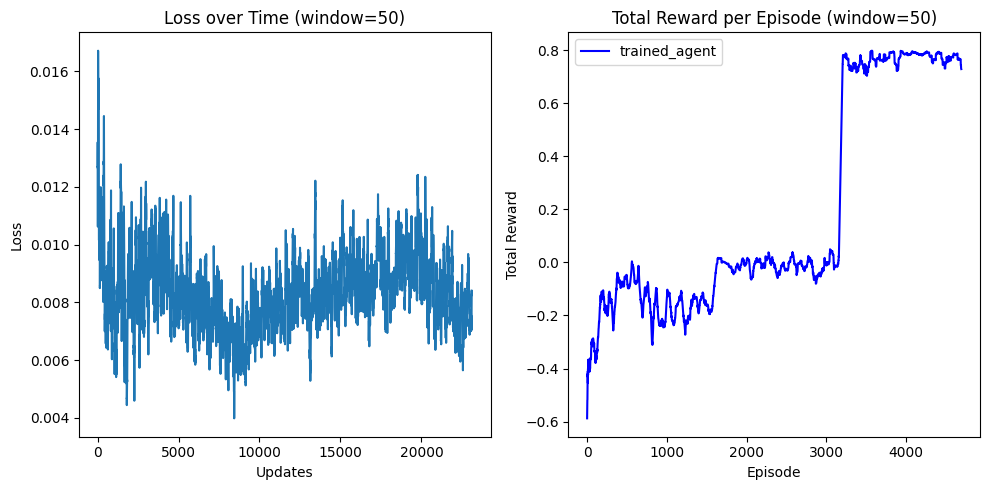

In [9]:
from benchmark.search_spaces.ghz_a.ghz_a_search_space_config import ghz_a_conf

seed = 40
start_time = time.time()
predictor_model_name="gcn_augmented_ghz_a"
env = create_env(ghz_a_conf, seed=seed, start_time=start_time,  predictor=True, model_name=predictor_model_name)
total_timesteps = 25000

rl_model, loss_history, rewards_history = start_experiment(total_timesteps, start_time, seed)
plot_results(loss_history, rewards_history)

In [71]:
from benchmark.search_spaces.ghz_a.evaluate_circuit_ghz_a import get_performance

def test_agent(env, rl_model, seed):
    print("Test agent")
    obs, info = env.reset()
    #dqn = DQN.load("A2C_ghz_a", env=env)
    while True:
        action, _states = rl_model.predict(obs, deterministic=False)
        obs, reward, done, truncated, info = env.step(int(action), train=True)
        if done or truncated:
            print(f"Total reward:{info['total_reward']}")
            print("''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''")
            print(f"Generated circuit: {info['circuit'].draw()}")
            print(f"Predicted performance:{reward}")
            
            def fidelity_loss(params):
                param_dict = dict(zip(trainable_circuit.parameters, params))
                if params.__sizeof__() > 0:
                    bound_circuit = trainable_circuit.assign_parameters(param_dict)
                else:
                    bound_circuit = trainable_circuit
                fidelity = get_performance(bound_circuit)
                return -fidelity
            
            
            def minimize_circ(circuit, params, search_space_config):
                initial_params = params
                bounds = [(search_space_config["optimizer_bound_min"], search_space_config["optimizer_bound_max"])] * len(
                    circuit.parameters) if circuit.parameters else None
                if circuit.parameters:
                    result = minimize(fidelity_loss,
                                      initial_params,
                                      method=search_space_config["optimizer"],
                                      options={'maxiter': search_space_config["optimizer_maxiter"]},
                                      bounds=bounds)
                    optimal_fidelity = result.fun
                    optimal_params = result.x
                    param_dict = dict(zip(circuit.parameters, optimal_params))
                    optimal_circuit = circuit.assign_parameters(param_dict)
                else:
                    optimal_fidelity = get_performance(circuit)
                    optimal_circuit = circuit
                return optimal_fidelity,optimal_circuit
            
            
    
            trainable_circuit, params = convert_qasm_circuit_into_trainable_pqc(qasm3.dumps(info['circuit']))
            ground_truth_fidelity_after_training, optimized_circuit = minimize_circ(trainable_circuit, params,
                                                                                ghz_a_conf)
            print("''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''")
            print(f"Ground truth performance for the trained PQC: {ground_truth_fidelity_after_training}")
            print("Ground truth optimized circuit", {optimized_circuit.draw()})
            break
    env.render()

In [72]:
test_agent(env, rl_model, seed)

Test agent
Total reward:0.8
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Generated circuit:      ┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘
Predicted performance:1.0
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Ground truth performance for the trained PQC: 1.0000000000000004
Ground truth optimized circuit {     ┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘}


In [73]:
env = create_env(ghz_a_conf, seed=1837, start_time=start_time,  predictor=True, model_name=predictor_model_name)
test_agent(env, rl_model, seed=1837)

Initialize state preparation ghz 3 qubits task
Test agent
Total reward:0.8
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Generated circuit:      ┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘
Predicted performance:1.0
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Ground truth performance for the trained PQC: 1.0000000000000004
Ground truth optimized circuit {     ┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘}


In [74]:
env = create_env(ghz_a_conf, seed=234, start_time=start_time,  predictor=True, model_name=predictor_model_name)
test_agent(env, rl_model, seed=234)

Initialize state preparation ghz 3 qubits task
Test agent
Total reward:0.8
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Generated circuit:      ┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘
Predicted performance:1.0
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Ground truth performance for the trained PQC: 1.0000000000000004
Ground truth optimized circuit {     ┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘}
